<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     

## <center> Kaggle inclass competition from [mlcourse.ai](https://mlcourse.ai/)
    
# <center> [**Dota 2 Winner Prediction**](https://www.kaggle.com/c/mlcourse-dota2-win-prediction/)

### <center> Session: Fall 2019

#### <div style="text-align: right"> Author: [Vladimir Kulyashov](https://www.kaggle.com/vovkaperm)


<div style="text-align: right"> creation date: 29 October 2019 </div>

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ujson as json
import eli5
from os import path
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from tqdm import tqdm_notebook
from IPython.display import display_html

In [2]:
PATH_TO_DATA = './data/'
PATH_TO_PREDS = './predictions/'
SEED = 17

skf = StratifiedKFold(n_splits=10, random_state=SEED)
logit = LogisticRegression(random_state=SEED, solver='lbfgs', max_iter=1000)
pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=2)
scaler = StandardScaler()

In [3]:
# Useful def's

def diff_of_quat(a1, a2):
    if a1 + a2 == 0: return 0
    else: return (a1-a2) / (a1 + a2)


def create_team_feature(feature):
    r_tmp = full_df[[f'r{i}_{feature}' for i in range(1,6)]]
    d_tmp = full_df[[f'd{i}_{feature}' for i in range(1,6)]]
    new_df[feature] = pd.concat([r_tmp.sum(axis=1), d_tmp.sum(axis=1)], axis=1).apply(lambda x: diff_of_quat(*x), axis=1)
    
def write_submission_file(predictions, filename):
    sub = pd.read_csv(path.join(PATH_TO_DATA,'sample_submission.csv'))
    sub['radiant_win_prob'] = predictions
    sub.to_csv(filename, index=False)
    print(f'Saved as {filename}')
    
def add_features(X, features_list):
    
    objects_to_hstack = [X]
    
    for feature in features_list:
        objects_to_hstack.append(feature)
        
    X_sparsed = hstack(objects_to_hstack)
    return X_sparsed

### Loading DATA

In [22]:
%%time
cols = pd.read_csv(path.join(PATH_TO_DATA, 'train_features.csv'), sep=',', nrows=1).columns
cols = list(set(cols) - {'match_id_hash'})

train_df = pd.read_csv(path.join(PATH_TO_DATA, 'train_features.csv'), sep=',', header=0, usecols=cols)
train_df = train_df[(train_df['game_mode'].isin([22,4,23]))&(train_df['game_time'] < 1000)]
train_targets = pd.read_csv(path.join(PATH_TO_DATA, 'train_targets.csv'), 
                            header=0, usecols=['radiant_win'], squeeze=True).astype('int')

train_targets = train_targets[train_df.index]

test_df = pd.read_csv(path.join(PATH_TO_DATA, 'test_features.csv'), sep=',', header=0, usecols=cols)


full_df = pd.concat([train_df, test_df])
idx = train_df.shape[0]
full_df.head(3)

Wall time: 1.69 s


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
1,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0
2,21,23,0,0,0,101,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0


In [23]:
# full_df[:idx]['game_mode'].value_counts(normalize=True)
# train_df['game_mode'].isin([22,4,23])
# train_targets[train_df.index]
print(train_df.shape)
train_targets.shape

(18217, 245)


(18217,)

### Adding features

In [24]:
%%time
team_features = ['kills',
                 'deaths',
                 'assists',
                 'gold',
                 'xp',
                 'denies',
                 'lh',
                 'level',
                 'max_health',
                 'max_mana',
                 'firstblood_claimed',
                 'teamfight_participation',
                 'towers_killed',
                 'obs_placed',
#                  'sen_placed',
#                  'rune_pickups',
#                  'roshans_killed',
#                  'stuns',
#                  'camps_stacked',
                ]

new_df = pd.DataFrame(index=full_df.index)

for feature in team_features:
    create_team_feature(feature)
    
# new_df['chat_len'] = scaler.fit_transform(full_df['chat_len'].values.reshape(-1, 1))
# team_features.append('chat_len')
# new_df['objectives_len'] = scaler.fit_transform(full_df['objectives_len'].values.reshape(-1, 1))
# team_features.append('objectives_len')
new_df['game_time'] = full_df['game_time'].values
# team_features.append('game_time')

new_df.head(3)

Wall time: 7.51 s


,kills,deaths,assists,gold,xp,denies,lh,level,max_health,max_mana,firstblood_claimed,teamfight_participation,towers_killed,obs_placed,game_time
0,-1.000000,1.0,-1.000000,-0.319298,-0.215369,-0.666667,-0.122807,-0.181818,0.000000,-0.132659,-1.0,-1.000000,0.0,-1.000000,155
1,0.684211,-0.6,0.647059,0.160557,0.152209,0.272727,0.139013,0.104478,0.070248,0.041403,-1.0,0.111111,1.0,-0.111111,658
2,0.000000,0.0,0.000000,0.294118,0.000000,0.000000,0.000000,0.000000,-0.003155,0.025788,0.0,0.000000,0.0,0.000000,21


In [32]:
X_train = new_df.drop(columns=['game_time'])[:idx].values
y_train = train_targets.values

X_test = new_df.drop(columns=['game_time'])[idx:].values

In [26]:
team_features_cv = cross_val_score(logit, X_train, y_train,
                                   scoring='roc_auc', cv=skf)
print(team_features_cv)
print(f'CV mean: {team_features_cv.mean(): 4f}')
print(f'CV max: {team_features_cv.max(): 4f}')

logit.fit(X_train, y_train)
preds = logit.predict_proba(X_test)
feature_importance = pd.DataFrame({'features': team_features,
                                   'coefs': logit.coef_[0]}).sort_values(by='coefs', ascending=False)
feature_importance

[0.72337013 0.74076186 0.71010592 0.74712419 0.75059746 0.72848221
 0.73595506 0.71752891 0.72916641 0.74164218]
CV mean:  0.732473
CV max:  0.750597


,features,coefs
7,level,3.804144
8,max_health,2.891095
3,gold,2.198004
0,kills,1.041513
6,lh,0.739548
5,denies,0.519945
2,assists,0.346281
12,towers_killed,0.310817
1,deaths,0.230614
9,max_mana,0.174049


In [27]:
team_features

['kills',
 'deaths',
 'assists',
 'gold',
 'xp',
 'denies',
 'lh',
 'level',
 'max_health',
 'max_mana',
 'firstblood_claimed',
 'teamfight_participation',
 'towers_killed',
 'obs_placed']

In [28]:
filename = f'sub_1.csv'
write_submission_file(preds, path.join(PATH_TO_PREDS, filename))

Saved as ./predictions/sub_1.csv


Initial submit gave **0.81678** on LB with the folowing features.

team_features = ['kills',
                 'deaths',
                 'assists',
                 'gold',
                 'xp',
                 'denies',
                 'lh',
                 'level',
                 'max_health',
                 'firstblood_claimed',
                 'teamfight_participation',
                 'towers_killed',
                 'obs_placed']

In [124]:
%%time
items = []
good_items_list = ['item_rod_of_atos',
                   'item_chainmail',
#                    'item_sheepstick',
                   'item_recipe_bloodthorn',
                   'item_satanic',
                   'item_mjollnir',
                   'item_recipe_black_king_bar',
                   'item_manta',
                   'item_claymore',
                   'item_recipe_sange',
                   'item_octarine_core',
                   'item_recipe_aeon_disk',
#                    'item_hood_of_defiance',
                   'item_broadsword',
                   'item_recipe_shivas_guard',
                   'item_necronomicon_3',
                   'item_ghost',
                   'item_dagon_5',
                   'item_recipe_hand_of_midas',
#                    'item_stout_shield',
                   'item_soul_booster',
                   'item_gem',]
good_ids = []

with open(r'./data/train_matches.jsonl', 'r') as f:
    for n, match in enumerate(f):
        match = json.loads(match)
        purchases = []
        has_good_items = []
        if match['game_time'] < 1000 and match['game_mode'] in [22,4,23]:
            for i, player in enumerate(match['players']):
                team = 'r' if i < 5 else 'd'
                purchases.extend([f'{team}_'+key for key, value in player['purchase'].items() for _ in range(value)])
                if team == 'r':
                    for item in player['hero_inventory']:
                        if item['id'] in good_items_list:
                            good_ids.append(n)
            items.append(' '.join(purchases))
                
                        

items_test = []
with open(r'./data/test_matches.jsonl', 'r') as f:
    for match in f:
        match = json.loads(match)
        purchases_test = []
        if match['game_time'] < 1000:
            for i, player in enumerate(match['players']):
                team = 'r' if i < 5 else 'd'
                purchases_test.extend([f'{team}_'+key for key, value in player['purchase'].items() for _ in range(value)])
            items_test.append(' '.join(purchases_test))
        
tfidf = TfidfVectorizer(tokenizer=lambda s: s.split())
items_matrix = tfidf.fit_transform(items)
items_matrix_test = tfidf.transform(items_test)

Wall time: 1min 47s


In [125]:
len(good_ids)

1279

In [126]:
has_good_items = new_df[:idx].reset_index()['index'].isin(good_ids).astype(int).values.reshape(-1, 1)
has_good_items.shape

(18217, 1)

In [127]:
X_train_short = new_df[:idx]
X_train_short = X_train_short[X_train_short['game_time'] < 1000].drop(columns=['game_time'])

In [128]:
y_train_short = y_train

X_test_short = new_df[idx:]
X_test_short = X_test_short[X_test_short['game_time'] < 1000].drop(columns=['game_time'])

In [129]:
X_train_short.shape

(18217, 14)

In [130]:
# X_train_short = add_features(X_train_short, [items_matrix])
# X_test_short = add_features(X_test_short, [items_matrix_test])
X_train_short = hstack([X_train_short, items_matrix, has_good_items])
X_test_short = hstack([X_test_short, items_matrix_test])
print(X_train_short.shape)
X_test_short.shape

(18217, 434)


(4748, 433)

In [131]:
cv_score = cross_val_score(logit, 
                           X_train_short, y_train_short,
                           scoring='roc_auc', cv=skf)

print(cv_score)
print(f'mean: {cv_score.mean()}')
print(f'max: {cv_score.max()}')

[0.72713947 0.74732128 0.72085898 0.75603156 0.76524795 0.74277645
 0.74220507 0.73307267 0.73795792 0.74851089]
mean: 0.7421122251255083
max: 0.7652479519123564


In [37]:
logit.fit(X_train_short, y_train_short)
preds = logit.predict_proba(X_test_short)
all_feature_names = tfidf.get_feature_names() + team_features
display_html(eli5.show_weights(estimator=logit, 
                  feature_names=all_feature_names, top=50))

# X_test_short.shape

Weight?,Feature
+3.559,d_basher
+2.324,d_belt_of_strength
+1.974,r_rod_of_atos
+1.850,r_chainmail
+1.815,r_sheepstick
+1.658,r_recipe_bloodthorn
+1.545,d_ancient_janggo
+1.402,r_satanic
+1.382,kills
+1.357,r_mjollnir


In [ ]:
filename = f'sub_2.csv'
write_submission_file(preds, path.join(PATH_TO_PREDS, filename))

### We try to devide data to categories by "game_time"

In [34]:
early_idx = full_df[full_df['game_time'] <= 600]['game_time'].index
mid_idx = full_df[(full_df['game_time'] > 600) & (full_df['game_time'] < 1800)]['game_time'].index
late_idx = full_df[full_df['game_time'] >= 1800]['game_time'].index

### Early phase

In [57]:
early_df = new_df[new_df['early_phase'] == 1].drop(['early_phase', 'mid_phase', 'late_phase'], axis=1)
early_targets = train_targets[early_idx]
early_df.head(2)

,kills,deaths,assists,gold,xp,denies,lh,level,max_health,max_mana,firstblood_claimed,teamfight_participation,towers_killed,obs_placed,sen_placed,rune_pickups,roshans_killed
0,-1.0,1.0,-1.0,-0.319298,-0.215369,-0.666667,-0.122807,-0.181818,0.000000,-0.132659,-1.0,-1.0,0.0,-1.0,0.0,-0.555556,0.0
2,0.0,0.0,0.0,0.294118,0.000000,0.000000,0.000000,0.000000,-0.003155,0.025788,0.0,0.0,0.0,0.0,0.0,0.500000,0.0


In [58]:
cv_score = cross_val_score(logit, 
                           early_df.values, early_targets.values,
                           scoring='roc_auc', cv=skf)

print(cv_score)
print(f'mean: {cv_score.mean()}')
print(f'max: {cv_score.max()}')

[0.68177491 0.6648593  0.69116736 0.70507214 0.66952071 0.67205896
 0.66781265 0.68058336 0.51151747 0.49257194]
mean: 0.6436938799737861
max: 0.7050721356276912


In [38]:
new_df['early_phase'] = (full_df['game_time'] <= 600).astype(int)
new_df['mid_phase'] = ((full_df['game_time'] > 600) & (full_df['game_time'] < 1800)).astype(int)
new_df['late_phase'] = (full_df['game_time'] >= 1800).astype(int)
new_df.head(10)

,kills,deaths,assists,gold,xp,denies,lh,level,max_health,max_mana,...,teamfight_participation,towers_killed,obs_placed,sen_placed,rune_pickups,roshans_killed,game_time,early_phase,mid_phase,late_phase
0,-1.000000,1.000000,-1.000000,-0.319298,-0.215369,-0.666667,-0.122807,-0.181818,0.000000,-0.132659,...,-1.000000,0.0,-1.000000,0.000000,-0.555556,0.0,155,1,0,0
1,0.684211,-0.600000,0.647059,0.160557,0.152209,0.272727,0.139013,0.104478,0.070248,0.041403,...,0.111111,1.0,-0.111111,0.200000,-0.037037,0.0,658,0,1,0
2,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.000000,0.000000,-0.003155,0.025788,...,0.000000,0.0,0.000000,0.000000,0.500000,0.0,21,1,0,0
3,0.714286,-0.555556,0.777778,0.083046,0.106391,0.563636,-0.080702,0.066667,-0.008403,0.081269,...,0.333333,0.0,0.142857,0.000000,0.083333,0.0,576,1,0,0
4,-0.333333,0.333333,0.200000,-0.063630,-0.050758,-1.000000,-0.239264,-0.019608,0.088785,0.093908,...,0.250000,0.0,0.000000,0.000000,0.157895,0.0,453,1,0,0
5,0.000000,0.000000,0.000000,0.230480,0.078643,0.285714,-0.027027,0.043478,0.032070,0.007450,...,0.000000,0.0,1.000000,0.000000,1.000000,0.0,160,1,0,0
6,-0.100000,0.090909,-0.040000,0.063662,-0.022916,-0.070423,0.131579,-0.010309,0.002740,0.007179,...,0.024390,0.0,-0.076923,0.333333,0.454545,0.0,1016,0,1,0
7,-0.250000,0.250000,-0.176471,-0.030331,-0.020794,-0.086420,0.119048,0.000000,0.043478,0.018546,...,0.040000,-1.0,-0.333333,-1.000000,-0.142857,0.0,582,1,0,0
8,-0.555556,0.400000,-0.142857,-0.165058,-0.150055,-0.585366,-0.246479,-0.081967,-0.052523,-0.265839,...,0.108911,0.0,0.000000,0.000000,-0.142857,0.0,636,0,1,0
9,0.120000,-0.120000,-0.041667,0.001712,0.016693,-0.240506,-0.073892,0.021277,0.100855,-0.046789,...,-0.106476,0.2,0.000000,0.333333,0.023256,0.0,1054,0,1,0


In [42]:
new_df.drop(columns=['game_time'], inplace=True)

In [43]:
logit.fit(new_df[:idx].values, train_targets.values)
preds = logit.predict_proba(new_df[idx:].values)
feature_importance = pd.DataFrame({'features': list(new_df.columns),
                                   'coefs': logit.coef_[0]}
                                 ).sort_values(by='coefs', ascending=False)

[0.79950719 0.81410051 0.79447593 0.8055666  0.81207731 0.80170612
 0.79726492 0.79733907 0.80515929 0.80999254]
CV mean:  0.803719
CV max:  0.814101


In [44]:
feature_importance

,features,coefs
7,level,7.098665
3,gold,4.106480
8,max_health,3.117840
9,max_mana,0.987275
0,kills,0.757929
6,lh,0.532154
2,assists,0.516733
1,deaths,0.454377
12,towers_killed,0.449735
15,rune_pickups,0.375412


In [32]:
full_df.iloc[early_idx, :]

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
2,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
3,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.000000,0,0,2,0
4,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.250000,0,0,0,0
5,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,179,22,7,1,0,68,1,0,0,1,...,0.000000,0,0,0,0,0.000000,0,0,1,0
9985,43,3,0,1,0,14,1,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
9987,2035,22,0,10,12,32,5,4,2,2,...,9.175501,0,0,3,0,0.433333,1,0,0,2
9991,1487,23,0,14,70,76,2,4,1,14,...,2.899218,2,1,8,1,0.448276,0,0,0,0


### Let's dive into JSON and find/make some awsome features :))

In [39]:
import json
matches = []
with open(path.join(PATH_TO_DATA, 'test_matches.jsonl')) as f:
    for i in range(500):
        line = f.readline()
        matches.append(json.loads(line))
    

In [67]:
for key, value in matches[10]['players'][0]['hero_inventory'][0].items():
    print(key)
    print(value)
# for item in player['hero_inventory']:
#                     if item['id'] in good_items_list:
#                         good_ids.append(n)

id
item_null_talisman
cooldown
0


(array([82., 87., 96., 91., 69., 36., 23.,  8.,  5.,  3.]),
 array([   5. ,  405.6,  806.2, 1206.8, 1607.4, 2008. , 2408.6, 2809.2,
        3209.8, 3610.4, 4011. ]),
 <a list of 10 Patch objects>)

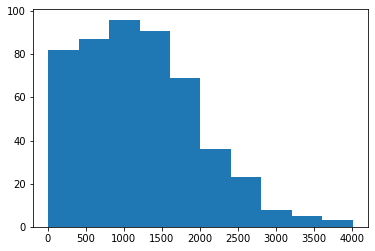

In [82]:
game_times = {i:matches[i]['game_time'] for i, _ in enumerate(matches)}
plt.hist(game_times.values())

In [ ]:
afk_players = pd.DataFrame()
for match in matches:
    for i, game in enumerate(match):
        if len(match['players'][i]['actions']) < 3:
            afk_players = afk_players.append(pd.DataFrame(data={'match_id_hash': match['match_id_hash'], 'afk': 1}, index=[i]))
        # else:
        #     afk_players = afk_players.append(pd.DataFrame(data={'afk_true': 0}, index=[match['match_id_hash']]))
            # print(f"player_slot {match['players'][i]['player_slot']} in match {match['match_id_hash']} was AFK")
afk_players

In [ ]:
afk_players = afk_players.groupby('match_id_hash').sum()
afk_players

In [ ]:
%time
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)
            
afk_players = pd.DataFrame()   
# processing each game
for match in read_matches('../data/train_matches.jsonl'):
    
   # processing each player
    for i, player in enumerate(match['players']):
        if len(match['players'][i]['actions']) < 5:
            afk_players = afk_players.append(pd.DataFrame(data={'match_id_hash': match['match_id_hash'], 'afk': 1}, index=[i]))

In [ ]:
afk_players = afk_players.groupby('match_id_hash').sum().reset_index()
print(afk_players.info())
afk_players.head()